In [5]:
import MDSplus as mds
import numpy as np
import pandas as pd
from scipy import signal
from MDSplus import mdsExceptions



In [6]:
long_pulse_shots = []
shots= np.arange(106915,116915)
# shots= np.arange(59636,69636)
cn = mds.Connection("mds.ipp.ac.cn")

# Peek long pulse shot

In [7]:
# Peek long pulse shot
for shot in shots:
    cn.openTree("pcs_east", shot)
    try:
        time_ip = cn.get("dim_of(\pcrl01)").data() # 等离子体电流
        ip = cn.get('\pcrl01').data()
    except mds.mdsExceptions.TreeNODATA:
        pass;
    else:
        print(ip[:10])
        if time_ip[-1] - time_ip[0] > 60 : # Existing time >= 60
            long_pulse_shots.append(shot)

long_pulse_shots

[  33.901978 -203.41187  -135.60791   610.2356   -169.50989   169.50989
   67.803955   33.901978 -203.41187    33.901978]
[ 135.60791   -33.901978  -67.803955  271.21582   203.41187     0.
  -33.901978 -101.70593   169.50989  -101.70593 ]
[-339.01978  -372.92175    33.901978    0.         67.803955    0.
  -67.803955   33.901978   33.901978  -67.803955]
[-101.70593    33.901978  339.01978   237.31384   271.21582   169.50989
 -101.70593  -169.50989   101.70593  -237.31384 ]
[   0.       -203.41187   169.50989  -372.92175    67.803955    0.
   67.803955    0.       -203.41187  -101.70593 ]
[ 203.41187  -339.01978  -372.92175   101.70593   101.70593  -508.52966
    0.       -169.50989   -67.803955 -169.50989 ]
[  0.       101.70593  135.60791  135.60791  -33.901978 169.50989
 101.70593   67.803955   0.        67.803955]
[-101.70593   -33.901978 -101.70593   -67.803955  203.41187   271.21582
 -271.21582   -67.803955  -33.901978   67.803955]
[-101.70593   -33.901978   67.803955  -33.901978 

KeyboardInterrupt: 

# Compute increase percent

In [4]:
# Get dau-alpha signals
def get_dau(shot, res_size = 1):
    """Get all DAU signals, return (time, DAUs)"""
    cn.openTree("east_1",shot)
    time = cn.get("dim_of(\DAU1)").data()[::res_size]
    DAUs = []
    for i in range(1,14):
        signal = "\DAU" + str(i)
        DAUs.append(cn.get(signal).data()[::res_size])

    return time,DAUs

time,DAUs = get_dau(long_pulse_shots[0],res_size=1000)
# time,DAUs = get_dau(long_pulse_shots[0],res_size=1000)


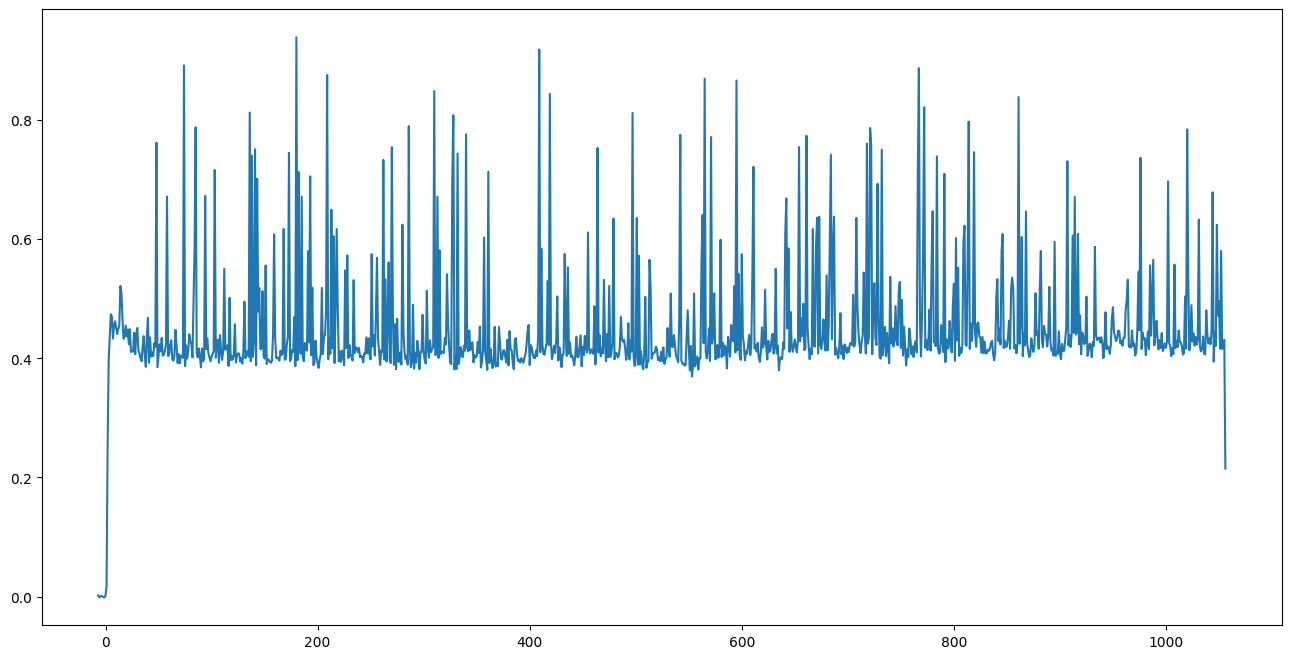

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,8))
plt.plot(time,DAUs[3])

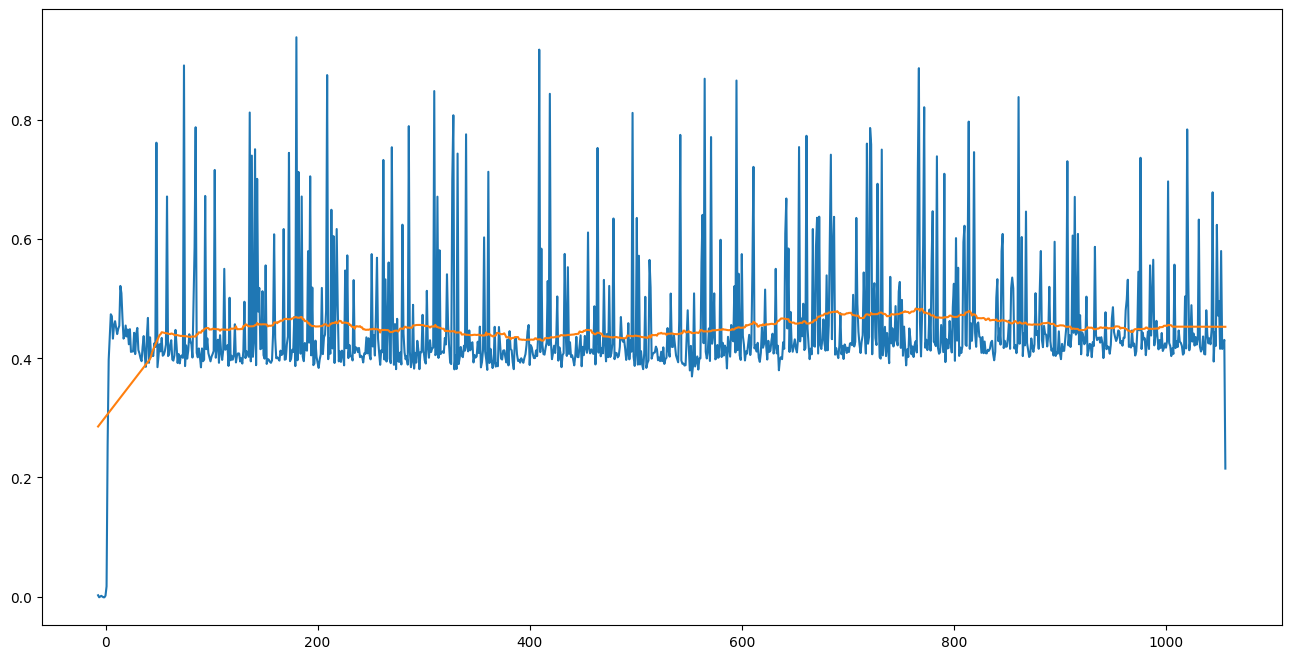

In [17]:

sm_DAU3 = signal.savgol_filter(DAUs[3],100,1)
plt.figure(figsize=(16,8))
plt.plot(time,DAUs[3])
plt.plot(time,sm_DAU3)

In [7]:
# Smooth the DAUs
smooth_DAUs = []
for i in range(len(DAUs)):
    smooth_DAUs.append(signal.savgol_filter(DAUs[i],100,3,mode='nearest'))


In [8]:
# Compute increase percent
smooth_DAUs = np.array(smooth_DAUs)


In [9]:
smooth_DAUs

array([[0.00500429, 0.00521482, 0.00543154, ..., 0.00877877, 0.00854746,
        0.0083138 ],
       [0.10753258, 0.11443107, 0.12150114, ..., 0.2055396 , 0.19977608,
        0.19411689],
       [0.11553615, 0.12315013, 0.13093641, ..., 0.27307674, 0.26686582,
        0.26092488],
       ...,
       [0.05489372, 0.05883041, 0.06279451, ..., 0.17078467, 0.1690001 ,
        0.1672461 ],
       [0.01346529, 0.01413066, 0.01481347, ..., 0.03374343, 0.03348529,
        0.03329489],
       [0.03245258, 0.03460816, 0.03676635, ..., 0.10380346, 0.10310655,
        0.1023044 ]], dtype=float32)

In [10]:
smooth_DAUs.max(axis=1)

array([1.5120880e-02, 3.3691090e-01, 4.1789424e-01, 4.9146828e-01,
       4.8472911e-01, 2.9590642e-01, 4.6279741e-04, 9.2244065e-01,
       4.6364564e-01, 2.7680388e-01, 2.1650681e-01, 4.1515332e-02,
       1.2868512e-01], dtype=float32)

In [11]:
smooth_DAUs.min(axis=1)

array([ 0.00500429,  0.10753258,  0.11553615,  0.14463827,  0.13249557,
        0.08212138, -0.00075831,  0.2673851 ,  0.11944389,  0.07469747,
        0.05489372,  0.01346529,  0.03245258], dtype=float32)

In [12]:
increase = (smooth_DAUs.max(axis=1) - smooth_DAUs.min(axis=1)) / smooth_DAUs.min(axis=1)
# increase = (max(smooth_DAUs))

In [13]:
increase

array([ 2.0215836,  2.1331055,  2.6169999,  2.3979132,  2.6584551,
        2.6032813, -1.6103044,  2.449858 ,  2.8817024,  2.705666 ,
        2.944109 ,  2.0831363,  2.9653273], dtype=float32)

In [15]:
def cal_increase(shots):
    """return the increase percent  of values of dau-alpha signals"""

    columns = [f'DAU{i}' for i in range(1,14)]

    df = pd.DataFrame(index=shots,columns=columns)
    for shot in shots:
        time,DAUs = get_dau(shot, res_size=1000)
        smooth_DAUs = []
        for i in range(len(DAUs)):
            smooth_DAUs.append(signal.savgol_filter(DAUs[i],100,3,mode='nearest'))
        smooth_DAUs = np.array(smooth_DAUs)
        increase = (smooth_DAUs.max(axis=1) - smooth_DAUs.min(axis=1)) / smooth_DAUs.min(axis=1)
        df.loc[shot] =  increase
    return df

df = cal_increase([596936])
df

TreeFOPENR: %TREE-E-FOPENR, Error opening file read-only.

In [ ]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
data = pd.read_csv('increase.csv',index_col='shot')

In [ ]:
data.head()